# GAN (10 баллов)

## Мотивация

GANы в их современном виде позволяют генерировать реалистичные изображения. Особенных успехов они добились в генерации лиц людей (модели семейства StyleGAN).

В этой домашке вы попробуете научиться генерировать лица кошек.

Как вы думаете, сложнее эта задача или проще?

## Задачи
1. Скачать датасет по [этому](https://drive.google.com/file/d/1uUctCNjIXYOwx_Pl57YCEBd4Qf6-NfFm/view?usp=sharing) адресу и разархивировать его в ту же папку, где лежит ноутбук
2. Заполнить пропуски в ноутбуке
3. Настроить гиперпараметры и обучить модель так, чтобы получались адекватные результаты
4. (Бонус) Выбрать, реализовать и обучить до приемлемых результатов не-ванильный GAN на ваш выбор

In [1]:
import itertools
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

## Загрузка данных

In [2]:
# Все изображения уже 64x64, работайте на этом разрешении
transform = torchvision.transforms.Compose([
    # Сконвертируйте изображение в тензор и приведите значения к [-1, 1]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])
dataset = torchvision.datasets.ImageFolder(root='cats_dataset', transform=transform)

Чтение большого количества маленьких файлов с диска может стать боттлнеком для производительности обучения, так что давайте считаем их все и будем хранить в памяти. Размер датасета это позволяет.

In [3]:
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = []
        for d in dataset:
            self.data.append(d)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [4]:
dataset = InMemoryDataset(dataset)

Визуализуйте несколько изображений датасета чтобы понять, что всё правильно читается

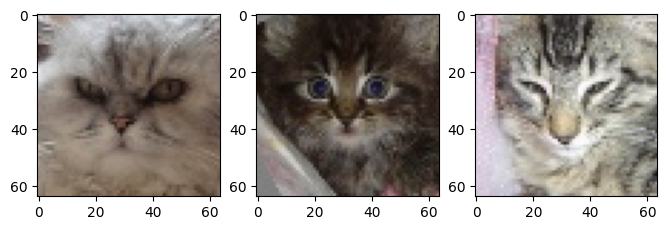

In [5]:
def denormalize(img):
    return (img + 1) / 2
# для корректного отображнения

fig, axes = plt.subplots(ncols=3, figsize=(8,8))

axes[0].imshow(denormalize(dataset[0][0].permute(1, 2, 0)))
axes[1].imshow(denormalize(dataset[1][0].permute(1, 2, 0)))
axes[2].imshow(denormalize(dataset[2][0].permute(1, 2, 0)))

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=2, shuffle=True, drop_last=True)

## Архитектуры сетей

Реализуйте архитектуры генератора и дискриминатора. В целом должно хватить простой архитектуры, не понадобится даже ResNet. В качестве хорошей стартовой архитектуры можно взять [DCGAN](https://paperswithcode.com/method/dcgan). Главное помните, что код нужно писать самому, и копировать его откуда бы то ни было запрещается.

Вы можете организовывать код как угодно, ниже просто предложен пример.

In [29]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels, scale=16):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=img_size*scale, kernel_size=4, bias=False),
            nn.BatchNorm2d(img_size*scale),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=img_size*scale, out_channels=img_size*scale//2, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(img_size*scale//2),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=img_size*scale//2, out_channels=img_size*scale//4, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(img_size*scale//4),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=img_size*scale//4, out_channels=img_size*scale//8, kernel_size=2, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(img_size*scale//8),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=img_size*scale//8, out_channels=channels, kernel_size=2, stride=2, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, img_size, channels, scale=2):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=img_size*scale, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=img_size*scale, out_channels=img_size*scale*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size*scale*2),
            nn.LeakyReLU(0.2),
        
            nn.Conv2d(in_channels=img_size*scale*2, out_channels=img_size*scale*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size*scale*4),
            nn.LeakyReLU(0.2),
        
            nn.Conv2d(in_channels=img_size*scale*4, out_channels=img_size*scale*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_size*scale*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=img_size*scale*8, out_channels=1, kernel_size=4),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return torch.flatten(self.model(x), 1)

In [30]:
summary(Generator(img_size=64, latent_dim=100, channels=3).to('cuda:0'), (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]         524,288
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         131,072
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           1,539
             Tanh-14            [-1, 3,

In [33]:
summary(Discriminator(img_size=64, channels=3).to('cuda:0'), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           6,272
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         524,288
       BatchNorm2d-4          [-1, 256, 16, 16]             512
         LeakyReLU-5          [-1, 256, 16, 16]               0
            Conv2d-6            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-7            [-1, 512, 8, 8]           1,024
         LeakyReLU-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-10           [-1, 1024, 4, 4]           2,048
        LeakyReLU-11           [-1, 1024, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]          16,385
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 11,036,289
Trainable para

In [34]:
# Если вы реализовываете DCGAN, не забудьте правильно инициализировать веса
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [36]:
device = 'cuda'
img_size = 64
n_channels = 3
latent_dim = 100

netG = Generator(img_size, latent_dim, n_channels).to(device)
netD = Discriminator(img_size, n_channels).to(device)
netG = netG.apply(weights_init)
netD = netD.apply(weights_init)

Создаём оптимизаторы. Обратите внимание на не-дефолтные параметры для betas, предложенные в DCGAN.

In [37]:
lr = 2e-4
b1 = 0.5
b2 = 0.999

optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(b1, b2))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(b1, b2))

## Код обучения

Как вы помните, генератор и дискриминатор соревнуются друг с другом.

Генератор принимает на вход шум и генерирует синтетические примеры. Он обучается так, чтобы дискриминатор считал эти изображения настоящими.

Дискриминатор:
1) принимает настоящие изображения и предсказывает, что они настоящие
2) принимает сгенерированные изображения и предсказывает, что они ненастоящие

In [38]:
# Заведём несколько переменных

# Количество обновлений дискриминатора и генератора на один шаг обучения
# Продвинутые схемы GAN варьируют это значение
Diters = 1
Giters = 1

# Метки для реальных и сгенерированных данных, использующиеся при обучении дискриминатора
label_R = 1
label_F = 0
# Метка для данных, полученных из генератора, использующаяся при обучении генератора
label_G = label_R

# Функции потерь
criterion_R = nn.BCELoss()
criterion_F = nn.BCELoss()
criterion_G = nn.BCELoss()

Предложенный код для заполнения использует tensorboard. Через него удобно контролировать процесс обучения.   
https://www.tensorflow.org/tensorboard/get_started    

Для запуска tensorboard используйте команду:
`tensorboard --logdir .`

Смотреть визуализации можно будет в браузере по дефолтному адресу [localhost:6006](localhost:6006).

В Google Colab такое не сработает, но есть cell magic `%tensorboard --logdir logs`, открывающая tensorboard в ячейке ноутбука.

In [18]:
%load_ext tensorboard

In [20]:
%tensorboard --logdir=tb_logs

Reusing TensorBoard on port 6006 (pid 7454), started 0:00:03 ago. (Use '!kill 7454' to kill it.)

In [39]:
# Зацикливаем даталоадер, чтобы можно было набирать произвольное количество батчей каждый шаг
data_iter = itertools.cycle(iter(dataloader))

# Для визуализации метрик и изображений
tb = SummaryWriter('tb_logs')

# Зададим параметры обучения
n_epochs = 50
sample_interval = 50

for epoch in range(n_epochs):
    for i in range(len(dataloader)):
        steps_done = epoch * len(dataloader) + i

        # Обучение дискриминатора
        j = 0
        while j < Diters:
            j += 1

            real, _ = next(data_iter)
            real = real.to(device)
            bs = real.shape[0]

            netD.zero_grad()

            # обучение на реальных данных
            real_target = torch.full((bs, 1), label_R, dtype=torch.float, device=device)
            outD_real = netD(real)
            errD_real = criterion_R(outD_real, real_target)
            errD_real.backward()

            # обучение на сгенерированных данных
            noise = torch.randn(size=(bs, latent_dim, 1, 1), device=device)
            fake = netG(noise)
            fake_target = torch.full((bs, 1), label_F, dtype=torch.float, device=device)
            outD_fake = netD(fake.detach())
            errD_fake = criterion_F(outD_fake, fake_target)
            errD_fake.backward()

            errD = errD_real + errD_fake

            tb.add_scalar('discriminator/real_loss', errD_real, global_step=steps_done)
            tb.add_scalar('discriminator/fake_loss', errD_fake, global_step=steps_done)
            tb.add_scalar('discriminator/loss', errD, global_step=steps_done)

            optimizerD.step()

        # Обучение генератора
        j = 0
        while j < Giters:
            j += 1

            netG.zero_grad()

            noise = torch.randn(size=(bs, latent_dim, 1, 1), device=device)

            fake = netG(noise)

            outG = netD(fake)
            gen_target = torch.full((bs, 1), label_G, dtype=torch.float, device=device)
            errG = criterion_G(outG, gen_target)
            errG.backward()

            optimizerG.step()

            tb.add_scalar('generator/loss', errG, global_step=steps_done)

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), errD.item(), errG.item())
        )

        if steps_done % sample_interval == 0:
            tb.add_images('images', fake[:24], global_step=steps_done)

[Epoch 0/50] [Batch 0/72] [D loss: 1.916279] [G loss: 22.918514]
[Epoch 0/50] [Batch 1/72] [D loss: 3.599239] [G loss: 13.595250]
[Epoch 0/50] [Batch 2/72] [D loss: 0.063907] [G loss: 3.165422]
[Epoch 0/50] [Batch 3/72] [D loss: 3.857208] [G loss: 20.985119]
[Epoch 0/50] [Batch 4/72] [D loss: 0.164070] [G loss: 29.379725]
[Epoch 0/50] [Batch 5/72] [D loss: 0.273883] [G loss: 32.078098]
[Epoch 0/50] [Batch 6/72] [D loss: 0.176435] [G loss: 32.216053]
[Epoch 0/50] [Batch 7/72] [D loss: 0.134274] [G loss: 31.366631]
[Epoch 0/50] [Batch 8/72] [D loss: 0.014368] [G loss: 29.905964]
[Epoch 0/50] [Batch 9/72] [D loss: 0.011590] [G loss: 27.745224]
[Epoch 0/50] [Batch 10/72] [D loss: 0.001001] [G loss: 21.631702]
[Epoch 0/50] [Batch 11/72] [D loss: 0.005749] [G loss: 13.305147]
[Epoch 0/50] [Batch 12/72] [D loss: 0.044541] [G loss: 10.068462]
[Epoch 0/50] [Batch 13/72] [D loss: 0.040500] [G loss: 13.601563]
[Epoch 0/50] [Batch 14/72] [D loss: 0.001332] [G loss: 13.903980]
[Epoch 0/50] [Batch 1

In [40]:
torch.save(netG.state_dict(), "netG.pt")
torch.save(netD.state_dict(), "netD.pt")

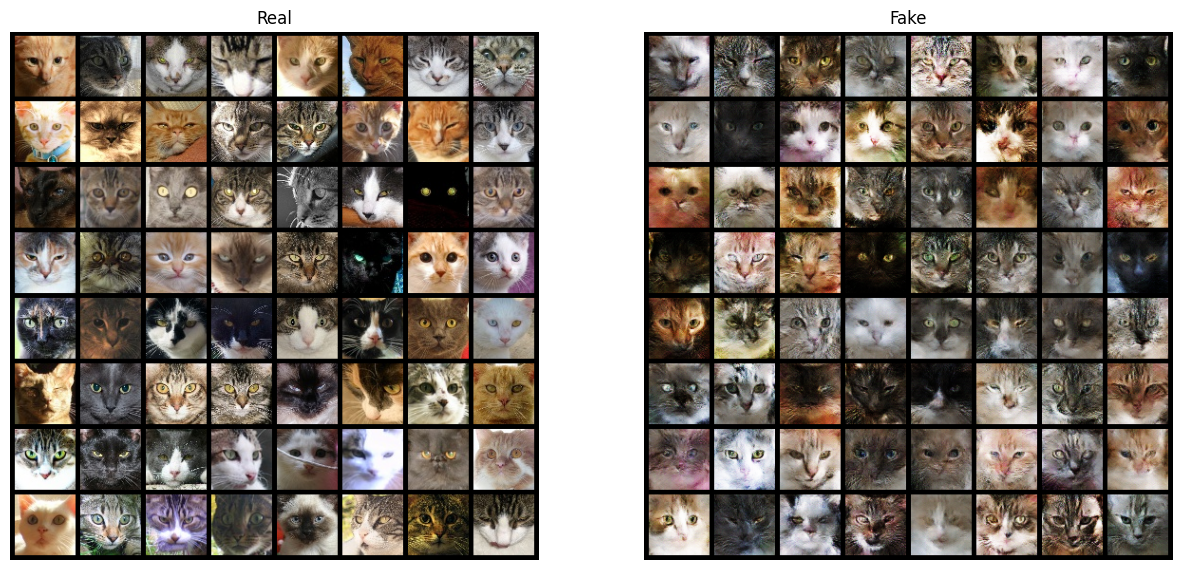

In [44]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real")
plt.imshow(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu().permute(1,2,0))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake")
plt.imshow(torchvision.utils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu().permute(1,2,0))
plt.show()

"Ванильные" GANы трудны в обучении, и исследователи выработали набор "хаков" (см. https://github.com/soumith/ganhacks). Вы можете воспользоваться ими, чтобы получить более хорошие результаты.

Поскольку у нас учебное задание, здесь "успехом" будем считать, если по крайней мере в 60% генерирующихся картинок будет понятно, что изображён кот, и не будет сильно бросающихся в глаза артефактов.

Есть ли какие-нибудь артефакты у изображения? Опишите их. Как вы думаете, почему они возникли (архитектура сетей, используемый лосс, ...)?

**Ваш ответ:** В целом качество визуально довольно хорошее, у некоторых фоток есть аномалии - рамытия, искажения форм и цветов. Вероятно качество можно немного улучшить, если просто увеличить количество параметров в генераторе(хотя у меня при изменении апсемплинга модель просто переставала сходится, но может это я просто фигово написал). Из-за того, что мы используем BCELoss модель сходится не очень стабильно.

In [61]:
noise = torch.randn(size=(50, latent_dim, 1, 1), device=device)
fake = netG(noise)
for i in range(50):
    plt.axis("off")
    plt.imshow(denormalize(fake[i].detach().cpu().permute(1, 2, 0)))
    plt.savefig(f"results/img_{i}.png")
    plt.close()

Ссылка на 50 примеров генерации: <https://drive.google.com/drive/folders/1pGBa_6H1KdTylWUURitzfwJmxWNvws5p?usp=sharing>

## (Дополнительно, 10 баллов) Обучение не-ванильных GAN

Ещё один способ улучшить результаты - использовать более современную функцию потерь, которая не имеет таких проблем, как ванильный GAN.

Выберите любой из вариантов (WGAN, WGAN-GP, Geometric GAN, ...) и попробуйте обучить сеть, используя данный лосс и методы.

Обязательно приведите здесь в ноутбуке весь код обучения и примеры генерирующихся картинок.

In [ ]:
# Ваш код

Помогло ли это улучшить качество картинок? Стабилизировать / упростить обучение?

**Ваш ответ:**